# Описание задачи

Датасет содержит информацию о более чем 100000 бронирований отелей с июля 2015 года по август 2017 года. Задача заключается в том, чтобы по имеющимся данным определить вероятность отмены брони.

In [1]:
import os
import numpy
import pandas
import matplotlib.pyplot
import seaborn
import sklearn
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network

In [2]:
DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(), 'hotel_booking.csv'))

In [3]:
dataset = pandas.read_csv(DATASET_PATH)
dataset.columns = dataset.columns.str.strip()

Число объектов и признаков:

In [4]:
dataset.shape

(119390, 36)

# Подготовка датасета

In [5]:
del dataset['reservation_status_date']
del dataset['country']
del dataset['reservation_status']
del dataset['name']
del dataset['email']
del dataset['phone-number']
del dataset['credit_card']

Удалим избыточные данные о желаемом времени заселения, оставив данные только о номере недели:

In [6]:
del dataset['arrival_date_year']
del dataset['arrival_date_month']
del dataset['arrival_date_day_of_month']

# Обработка пропущенных значений

In [7]:
dataset['meal'] = dataset['meal'].replace({'Undefined': None})
dataset['market_segment'] = dataset['market_segment'].replace({'Undefined': None})
dataset['distribution_channel'] = dataset['distribution_channel'].replace({'Undefined': None})

Посмотрим в каких столбцах имеются пропущенные значения:

In [8]:
dataset.isna().sum()[dataset.isna().sum() != 0]

,0
children,4
meal,1169
market_segment,2
distribution_channel,5
agent,16340
company,112593


Пропуски в признаках children, meal, market_segment и distribution_channel заменим на моду:

In [9]:
dataset['children'] = dataset['children'].fillna(dataset['children'].mode()[0])
dataset['meal'] = dataset['meal'].fillna(dataset['meal'].mode()[0])
dataset['market_segment'] = dataset['market_segment'].fillna(dataset['market_segment'].mode()[0])
dataset['distribution_channel'] = dataset['distribution_channel'].fillna(dataset['distribution_channel'].mode()[0])

Признаки agent и company содержат идентификатор агенства и компании соответственно. В данном случае пропуски можно связать с тем, что бронирующий не был связан с компанией или агентсвом.

In [10]:
dataset['agent'] = dataset['agent'].fillna(0)
dataset['company'] = dataset['company'].fillna(0)

In [11]:
dataset['agent'] = numpy.where(dataset['agent'] > 0, 1, 0)
dataset['company'] = numpy.where(dataset['company'] > 0, 1, 0)

# Обработка категориальных признаков

In [12]:
dataset = pandas.get_dummies(dataset)

# Визуализация

Изучим основные метрики:

In [13]:
dataset.describe()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,27.165173,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,0.863138,0.056931,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,13.605138,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,0.343703,0.231712,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,28.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,38.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,53.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,1.000000,1.000000,391.000000,5400.000000,8.000000,5.000000


Можно заметить подозрительные значения, так max у adults составляет 55 человек.
Посмотрим что это за записи:

In [14]:
dataset[dataset['adults'] > 10]

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
1539,1,304,36,0,3,40,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1587,1,333,36,2,5,26,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1643,1,336,37,1,2,50,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1752,1,340,37,2,5,26,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1884,1,347,38,2,5,26,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1917,1,349,39,1,3,27,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1962,1,352,39,1,3,27,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2003,1,354,39,2,5,26,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2164,1,361,40,2,5,26,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2173,1,338,41,2,0,55,0.0,0,0,0,...,False,False,False,True,False,False,False,True,False,False


Видно, что все эти бронирования были отменены, причём залог не вносился. Следует оставить эти значения как пример изначально крайне подозрительных.

<Axes: >

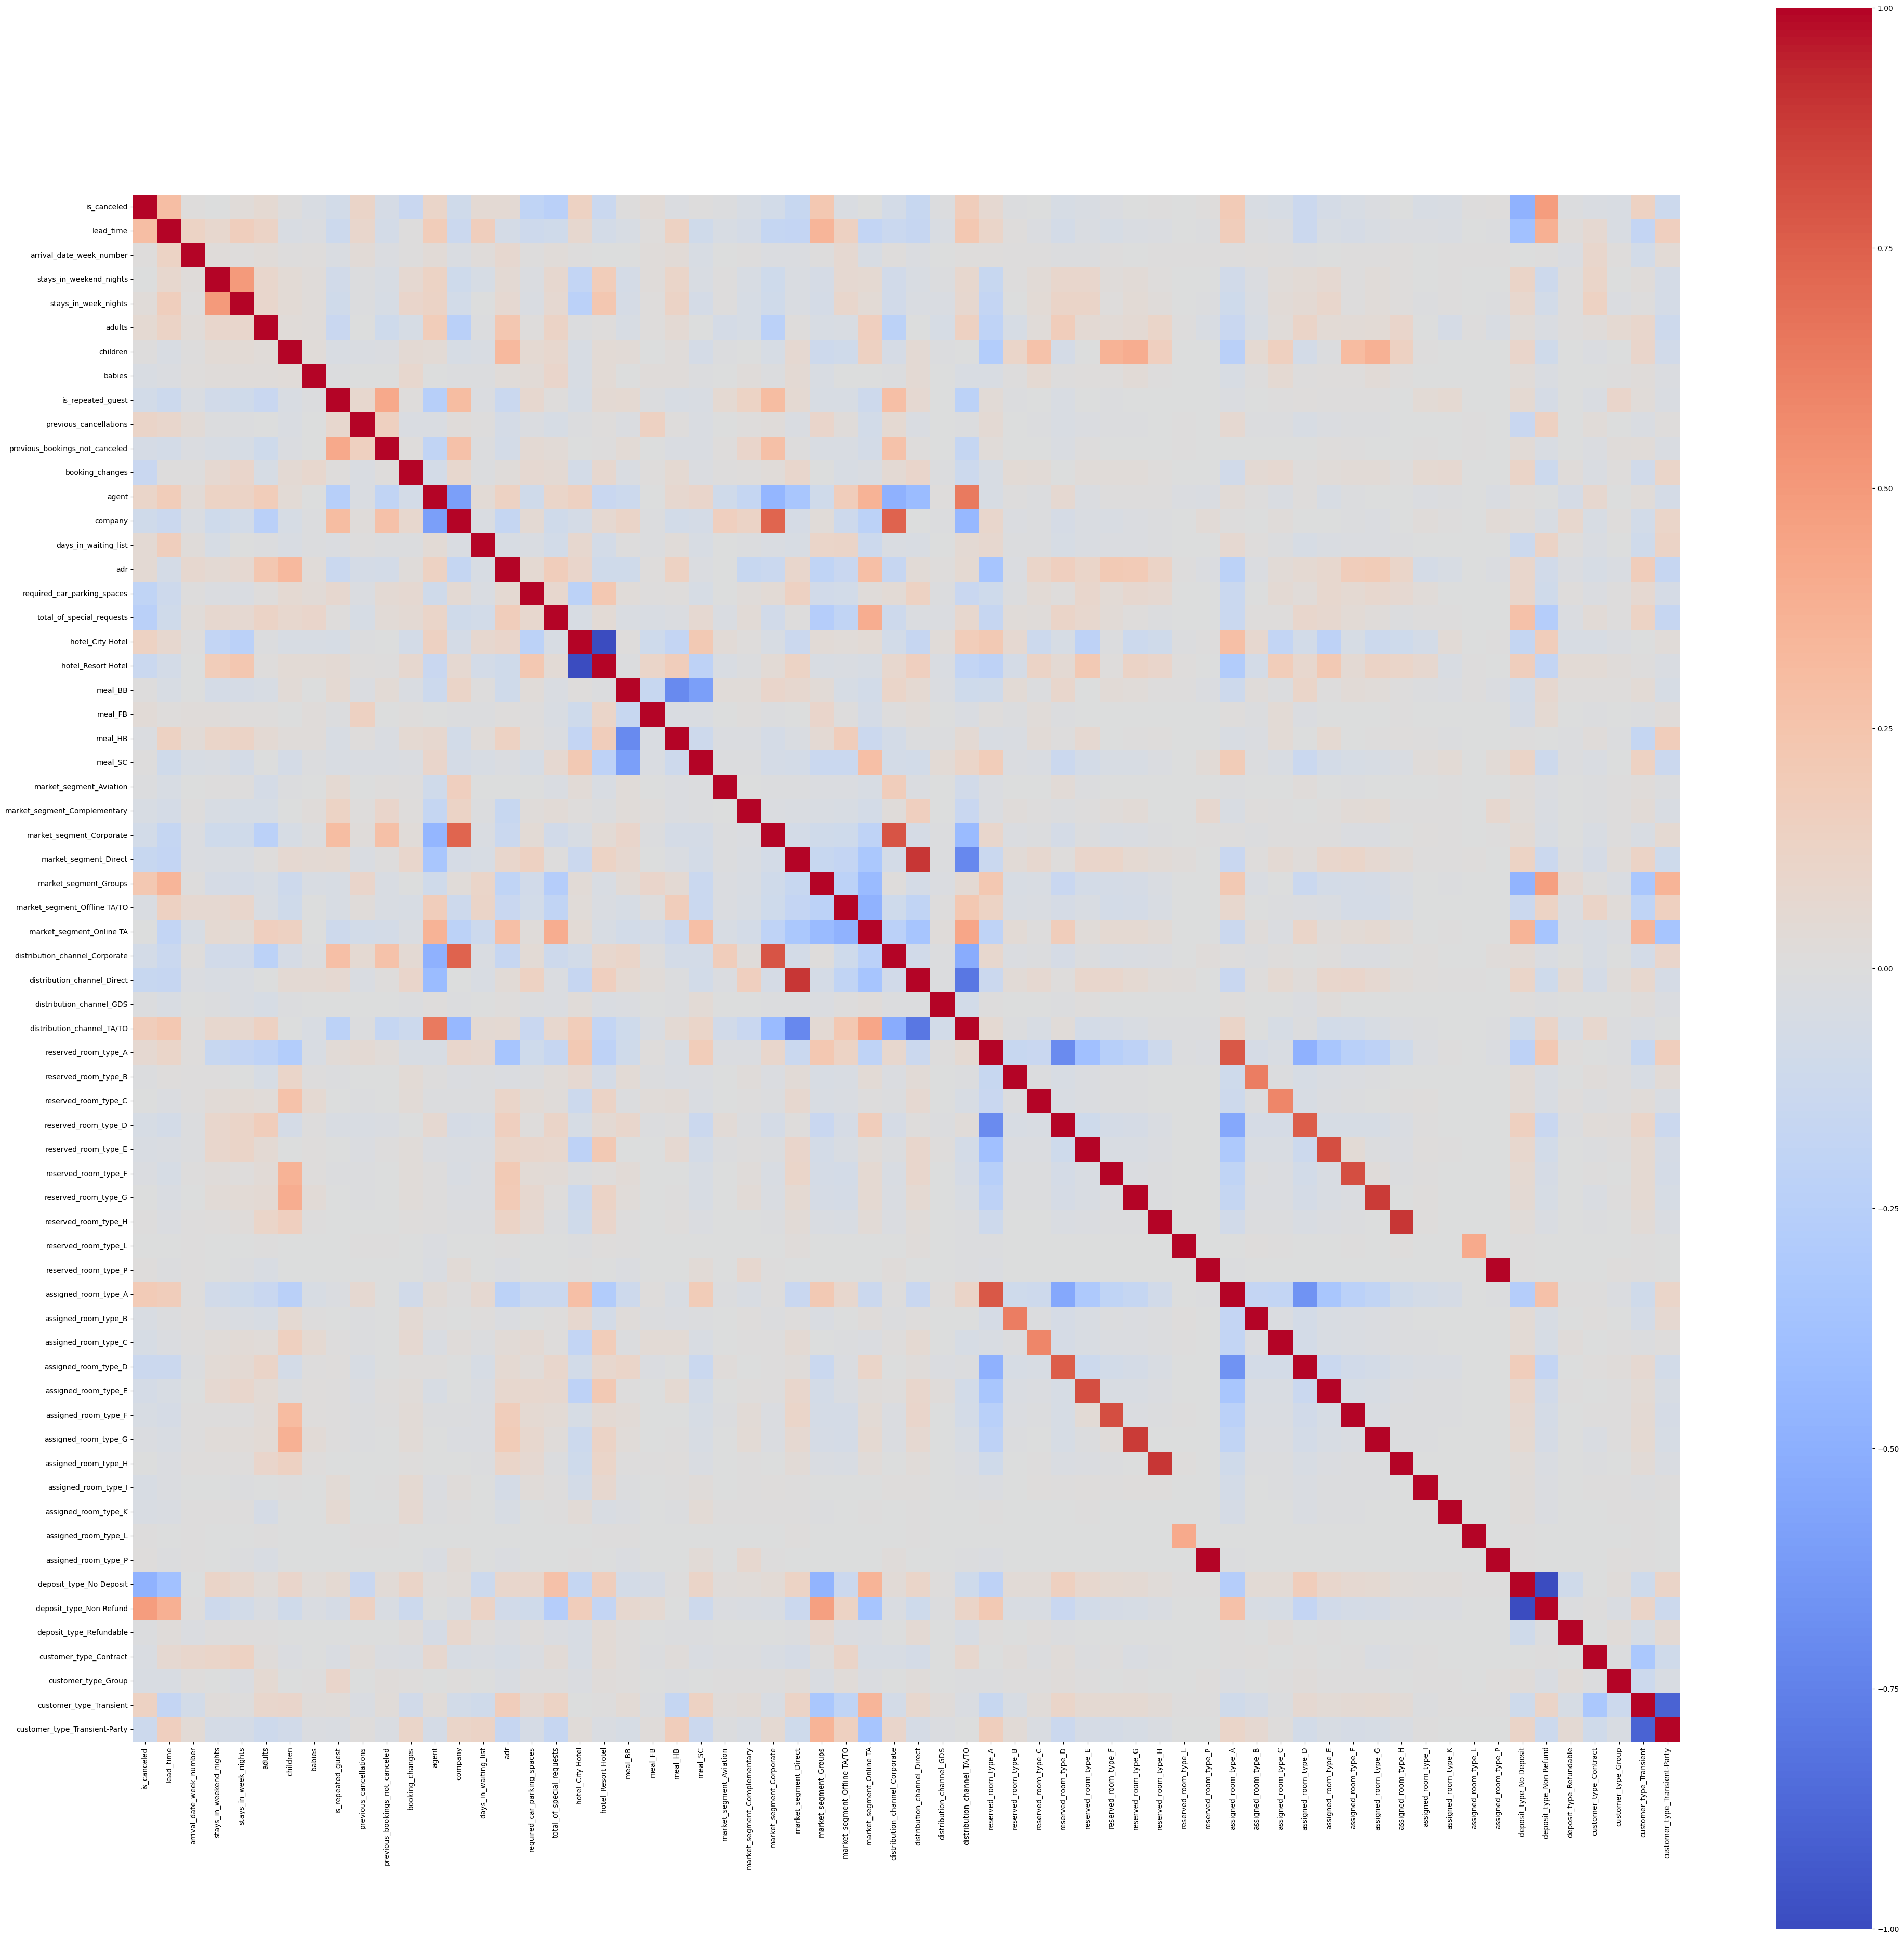

In [15]:
correlation_matrix = dataset.corr()
matplotlib.pyplot.figure(figsize = (48, 48))
seaborn.heatmap(correlation_matrix, square=True, cmap="coolwarm")

Text(0.5, 1.0, 'Зависимость числа ночей от недели прибытия')

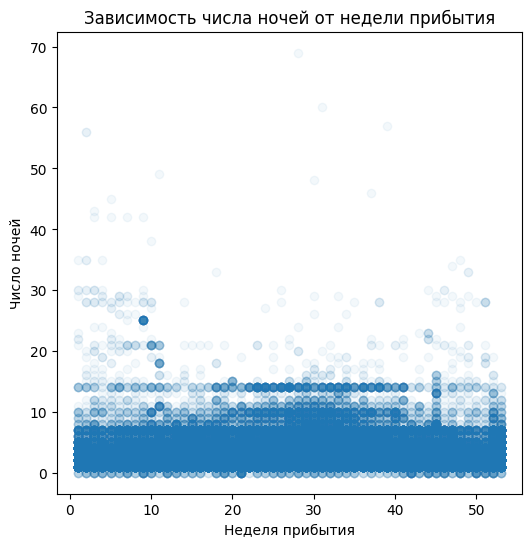

In [16]:
matplotlib.pyplot.figure(figsize = (6, 6), dpi=100)
matplotlib.pyplot.plot(dataset['arrival_date_week_number'], dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights'], 'o', alpha = 0.05)
matplotlib.pyplot.xlabel('Неделя прибытия')
matplotlib.pyplot.ylabel('Число ночей')
matplotlib.pyplot.title('Зависимость числа ночей от недели прибытия')

# Нормализация признаков

Нормализацию проведём методом стандартизации:

In [17]:
dataset_normalized = (dataset - dataset.mean(axis = 0)) / dataset.std(axis = 0)
dataset_normalized.describe()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,...,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05,1.193900e+05
mean,-9.522308e-17,7.617847e-18,-1.285512e-16,-2.416286e-17,-7.617847e-18,9.522308e-19,-7.046508e-17,5.177755e-17,-1.618792e-17,-2.761469e-17,...,-4.761154e-18,-1.577132e-18,4.642125e-18,-1.275989e-16,-6.856062e-17,1.904462e-18,5.713385e-18,2.285354e-17,-1.971118e-16,-1.133155e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.670373e-01,-9.733146e-01,-1.923183e+00,-9.288865e-01,-1.310234e+00,-3.204779e+00,-2.606575e-01,-8.157892e-02,-1.815596e-01,-1.031791e-01,...,-4.839766e-02,-2.894117e-03,-1.002598e-02,-2.663593e+00,-3.730734e-01,-3.686095e-02,-1.880071e-01,-6.968738e-02,-1.734775e+00,-5.162559e-01
25%,-7.670373e-01,-8.048748e-01,-8.206585e-01,-9.288865e-01,-7.862039e-01,2.478962e-01,-2.606575e-01,-8.157892e-02,-1.815596e-01,-1.031791e-01,...,-4.839766e-02,-2.894117e-03,-1.002598e-02,3.754296e-01,-3.730734e-01,-3.686095e-02,-1.880071e-01,-6.968738e-02,5.764387e-01,-5.162559e-01
50%,-7.670373e-01,-3.276287e-01,6.136116e-02,7.250190e-02,-2.621733e-01,2.478962e-01,-2.606575e-01,-8.157892e-02,-1.815596e-01,-1.031791e-01,...,-4.839766e-02,-2.894117e-03,-1.002598e-02,3.754296e-01,-3.730734e-01,-3.686095e-02,-1.880071e-01,-6.968738e-02,5.764387e-01,-5.162559e-01
75%,1.303707e+00,5.239281e-01,7.963776e-01,1.073890e+00,2.618573e-01,2.478962e-01,-2.606575e-01,-8.157892e-02,-1.815596e-01,-1.031791e-01,...,-4.839766e-02,-2.894117e-03,-1.002598e-02,3.754296e-01,-3.730734e-01,-3.686095e-02,-1.880071e-01,-6.968738e-02,5.764387e-01,-5.162559e-01
max,1.303707e+00,5.923360e+00,1.898902e+00,1.809749e+01,2.489129e+01,9.174379e+01,2.482997e+01,1.025497e+02,5.507786e+00,3.069024e+01,...,2.066198e+01,3.455257e+02,9.974008e+01,3.754296e-01,2.680415e+00,2.712875e+01,5.318904e+00,1.434968e+01,5.764387e-01,1.937008e+00


# Классификация

Разделим данные на обучающую и тестовую выборку с соотношением 3 к 1:

In [18]:
x = dataset_normalized.drop(['is_canceled'], axis=1)
y = dataset['is_canceled']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, random_state=42)

## K ближайших соседей

4 соседа:

In [19]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(x_train.values, y_train.values)
y_train_pred = model.predict(x_train.values)
y_test_pred = model.predict(x_test.values)
print(f'Ошибки:\nОбучающая: {sklearn.metrics.mean_squared_error(y_train, y_train_pred)}, Тестовая: {sklearn.metrics.mean_squared_error(y_test, y_test_pred)}')

Ошибки:
Обучающая: 0.11953049965379375, Тестовая: 0.1706982042347896


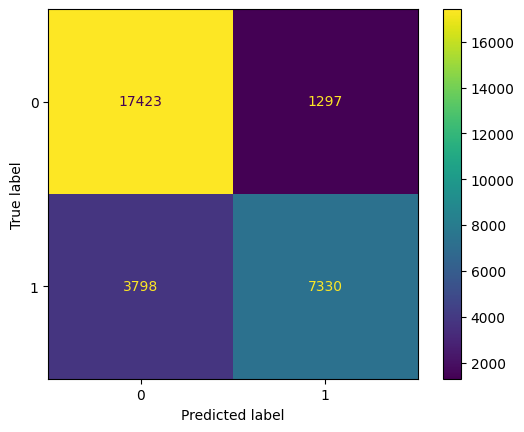

In [20]:
confusion_maxtrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_maxtrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_maxtrix, display_labels=model.classes_)
confusion_maxtrix_display.plot()
matplotlib.pyplot.show()

8 соседей:

In [21]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=8)
model.fit(x_train.values, y_train.values)
y_train_pred = model.predict(x_train.values)
y_test_pred = model.predict(x_test.values)
print(f'Ошибки:\nОбучающая: {sklearn.metrics.mean_squared_error(y_train, y_train_pred)}, Тестовая: {sklearn.metrics.mean_squared_error(y_test, y_test_pred)}')

Ошибки:
Обучающая: 0.1408836076924795, Тестовая: 0.1714687751273117


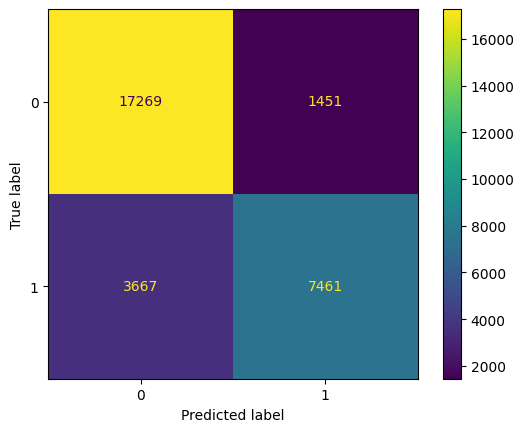

In [22]:
confusion_maxtrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_maxtrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_maxtrix, display_labels=model.classes_)
confusion_maxtrix_display.plot()
matplotlib.pyplot.show()

Подбор оптимального количества ближайших соседей:

In [23]:
model = sklearn.neighbors.KNeighborsClassifier()
grid = sklearn.model_selection.GridSearchCV(model, param_grid = {'n_neighbors': range(1, 11)}, cv=10)
grid.fit(x_train.values, y_train.values)
print(f"Оптимальное количество соседей: {grid.best_params_['n_neighbors']}")

best_model = grid.best_estimator_
y_train_pred = best_model.predict(x_train.values)
y_test_pred = best_model.predict(x_test.values)
print(f'\nОшибки:\nОбучающая: {sklearn.metrics.mean_squared_error(y_train, y_train_pred)}, Тестовая: {sklearn.metrics.mean_squared_error(y_test, y_test_pred)}')

Оптимальное количество соседей: 4

Ошибки:
Обучающая: 0.11953049965379375, Тестовая: 0.1706982042347896


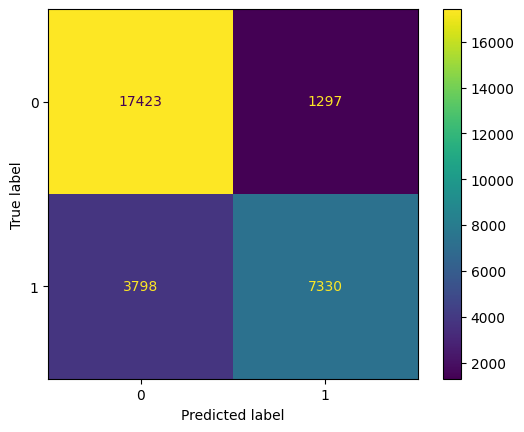

In [24]:
confusion_maxtrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_maxtrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_maxtrix, display_labels=best_model.classes_)
confusion_maxtrix_display.plot()
matplotlib.pyplot.show()

## Random Forest

In [25]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(x_train.values, y_train.values)
y_train_pred = model.predict(x_train.values)
y_test_pred = model.predict(x_test.values)
print(f'Ошибки:\nОбучающая: {sklearn.metrics.mean_squared_error(y_train, y_train_pred)}, Тестовая: {sklearn.metrics.mean_squared_error(y_test, y_test_pred)}')

Ошибки:
Обучающая: 0.007627705434321324, Тестовая: 0.13076253015277406


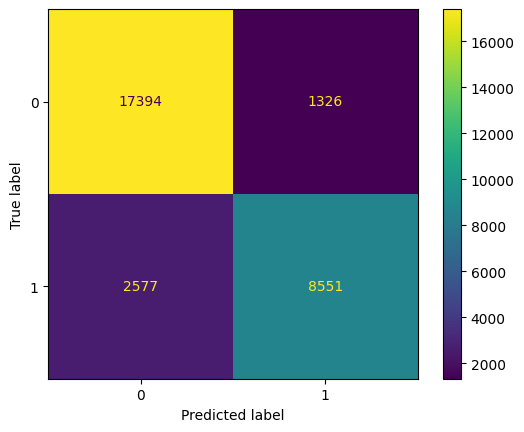

In [26]:
confusion_maxtrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_maxtrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_maxtrix, display_labels=model.classes_)
confusion_maxtrix_display.plot()
matplotlib.pyplot.show()

# Выводы

- Увеличение числа соседей незначительно снизило точность работы модели;
- Применение random forest позволило ощутимо снизить ошибку;
- Обученные алгоритмы хорошо предсказывают негативные случаи, но часто путаются в позитивных.